<a href="https://colab.research.google.com/github/Tapish0305/PCB-defect/blob/main/pcb_defect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import os

from tqdm import tqdm
import argparse
import glob
import xml.etree.ElementTree as ET
import cv2
import ast
import numpy as np


import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as immg

import random
import sys

import torch

import torchvision
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split



import warnings
warnings.filterwarnings("ignore")

In [ ]:
# !pip install albumentations==0.4.6
import albumentations as A
from albumentations.pytorch import ToTensorV2

# I. Generate CSV

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("akhatova/pcb-defects")
pathy = path
print("Path to dataset files:", path)


Path to dataset files: /root/.cache/kagglehub/datasets/akhatova/pcb-defects/versions/1


In [ ]:
dataset = {
            "xmin":[],
            "ymin":[],
            "xmax":[],
            "ymax":[],
            "class":[],
            "file":[],
            "width":[],
            "height":[],
           }
all_files = []
for path, subdirs, files in os.walk(path):
#     print([path, subdirs, files])
    for name in files:
        all_files.append(os.path.join(path, name))

print(type(dataset))
print(dataset)

<class 'dict'>
{'xmin': [], 'ymin': [], 'xmax': [], 'ymax': [], 'class': [], 'file': [], 'width': [], 'height': []}


In [ ]:
for anno in all_files:
     # Check if the file is an XML file

    if anno.lower().endswith('.xml' or '.JPG' or 'jpg'):
      # Only process files ending with '.xml'
       tree = ET.parse(anno)
       #XML (Raw Text) → ElementTree (Structured Object in Memory)

       for elem in tree.iter():
          # print(elem)

          if 'size' in elem.tag:

              for attr in list(elem):
                  if 'width' in attr.tag:
                      width = int(round(float(attr.text)))
                  if 'height' in attr.tag:
                      height = int(round(float(attr.text)))

          if 'object' in elem.tag:

              for attr in list(elem):


                  if 'name' in attr.tag:
                      name = attr.text
                      dataset['class']+=[name]
                      dataset['width']+=[width]
                      dataset['height']+=[height]
                      dataset['file']+=[anno.split('/')[-1][0:-4]]
                              ## example - 04_mouse_bite_02
                  if 'bndbox' in attr.tag:
                      for dim in list(attr):
                          if 'xmin' in dim.tag:
                              xmin = int(round(float(dim.text)))
                              dataset['xmin']+=[xmin]
                          if 'ymin' in dim.tag:
                              ymin = int(round(float(dim.text)))
                              dataset['ymin']+=[ymin]
                          if 'xmax' in dim.tag:
                              xmax = int(round(float(dim.text)))
                              dataset['xmax']+=[xmax]
                          if 'ymax' in dim.tag:
                              ymax = int(round(float(dim.text)))
                              dataset['ymax']+=[ymax]

In [ ]:
data=pd.DataFrame(dataset)
data

xmin  ymin  xmax  ymax            class                   file  width  \
0     1807  1484  1902  1552            short            12_short_09   2529   
1     2180   823  2260   884            short            12_short_09   2529   
2      757  1581   813  1648            short            12_short_09   2529   
3     1493  1888  1555  1961            short            12_short_09   2529   
4       77  1881   158  1943            short            12_short_09   2529   
...    ...   ...   ...   ...              ...                    ...    ...   
2948  1237   874  1291   992  spurious_copper  10_spurious_copper_05   2240   
2949  1365  1293  1414  1377  spurious_copper  10_spurious_copper_05   2240   
2950  1666   612  1746   652  spurious_copper  01_spurious_copper_14   3034   
2951   743  1190   805  1267  spurious_copper  01_spurious_copper_14   3034   
2952  1184  1091  1343  1156  spurious_copper  01_spurious_copper_14   3034   

      height  
0       2530  
1       2530  
2       2530  
3       2530  
4       2530  
...      ...  
2948    2016  
2949    2016  
2950    1586  
2951    1586  
2952    1586  

[2953 rows x 8 columns]

# II. Reading the CSV file

In [ ]:
df = data.copy()
train, test = train_test_split(data, shuffle=True, test_size=0.2, random_state=34)

In [ ]:
train.shape, test.shape, df.shape

((2362, 8), (591, 8), (2953, 8))

In [ ]:
classes_la = {"missing_hole": 1, "mouse_bite": 2, "open_circuit":3, "short": 4, 'spur': 5,'spurious_copper':6}

df["class"] = df["class"].apply(lambda x: classes_la[x])
train["class"] = train["class"].apply(lambda x: classes_la[x])
test["class"] = test["class"].apply(lambda x: classes_la[x])

In [ ]:
print("Data Frame Size ", len(df))
print("Train Size ", len(train))
print("Test Size ", len(test))

Data Frame Size  2953
Train Size  2362
Test Size  591


# III. Visualization

In [ ]:
def plot_image(image_name):
    print(image_name)
    image_group = data.groupby("file").get_group(image_name)
    bbox = image_group.loc[:,['xmin', 'ymin', 'xmax', 'ymax']]
    path ="/root/.cache/kagglehub/datasets/akhatova/pcb-defects/versions/1/PCB_DATASET/images/"
    if "missing" in name.split('_'):
        path += 'Missing_hole/'
    if "mouse" in name.split('_'):
        path += 'Mouse_bite/'
    if "open" in name.split('_'):
        path += 'Open_circuit/'
    if "short" in name.split('_'):
        path += 'Short/'
    if "spur" in name.split('_'):
        path += 'Spur/'
    if "spurious" in name.split('_'):
        path += 'Spurious_copper/'

    img = immg.imread(path+""+name+'.jpg')
    fig,ax = plt.subplots(figsize=(18,10))
    ax.imshow(img,cmap='binary')
    for i in range(len(bbox)):
        box = bbox.iloc[i].values
        print(box)
        x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none',)
        # ax.text(*box[:2], image_group["class"].values, verticalalignment='top', color='white', fontsize=13, weight='bold')
        ax.add_patch(rect)
    plt.show()

09_spur_05
[1125  712 1167  789]
[1840 1200 1882 1276]
[1943 1131 1986 1228]
[1140  433 1190  507]
[1061 1112 1102 1177]


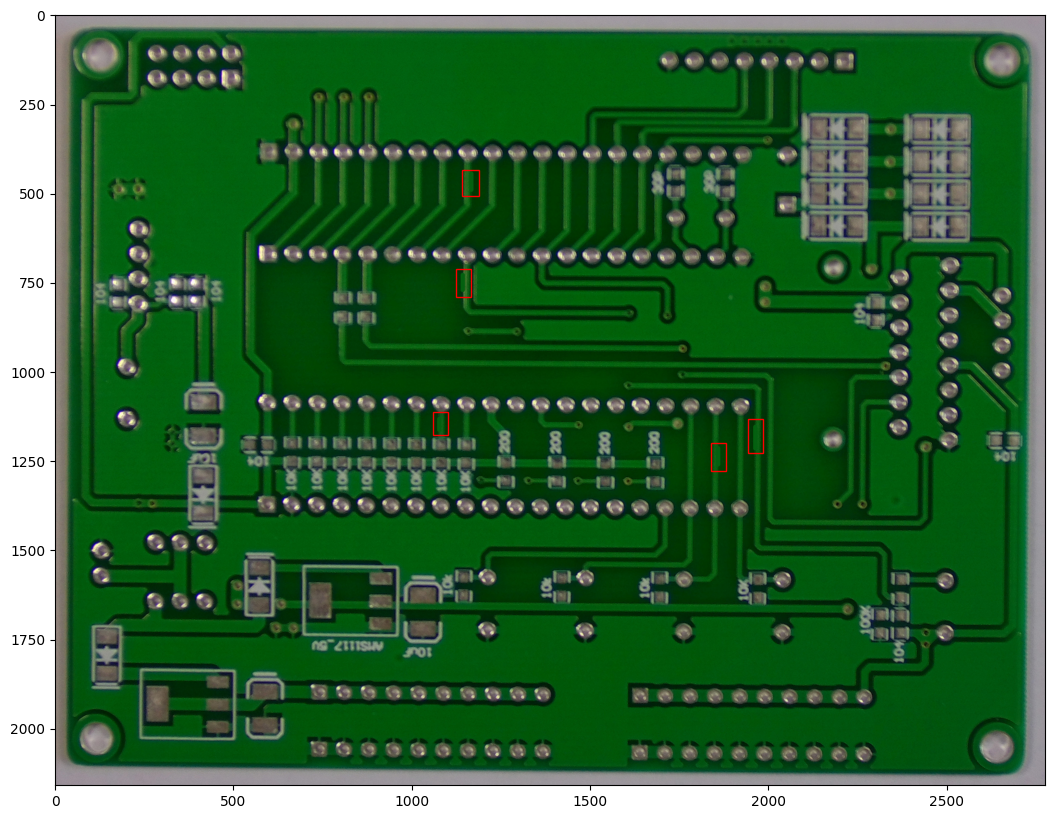

In [ ]:
name = data.file[605]
plot_image(name)

# IV. Creating Custom database

In [ ]:
class pcbdata(object):
  def __init__(self, df, img_dir, transforms):
    self.df = df ## image dataframe
    self.img_dir = img_dir ## contain image path
    self.transforms = transforms ## apply transformation or not
    self.image_ids = self.df['file'].unique().tolist() ## [.unique] convert image_ids like "01_missing_hole_06" into a array form
                                                       ##  array converts into list


  def __len__(self):
    return len(self.image_ids) ## calculate the length of the list of image ids

  def __getitem__(self, idx):
    image_id = self.image_ids[idx]

    if "missing" in image_id.split('_'):
        a =  'Missing_hole/'
    if "mouse" in image_id.split('_'):
        a = 'Mouse_bite/'
    if "open" in image_id.split('_'):
        a = 'Open_circuit/'
    if "short" in image_id.split('_'):
        a = 'Short/'
    if "spur" in image_id.split('_'):
        a = 'Spur/'
    if "spurious" in image_id.split('_'):
        a = 'Spurious_copper/'

    image_values = self.df[self.df['file']==image_id] ## contain dataset that contain images
    image = cv2.imread(self.img_dir + a + image_id + '.jpg', cv2.IMREAD_COLOR) ## read the image data path and take all color using IMREAD_COLOR
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) ## convert the image into RGB form from BRG form
    image /= 255.0 ## normalize the image

    boxes = image_values[['xmin', 'ymin', 'xmax', 'ymax']].to_numpy() ## contain the orrdinates of the boxes in numpy array
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) ## compute box to calculate IOU

    labelss = image_values['class'].values ## contain the type of defect that pcb have

    target = {}
    target['boxes'] = boxes
    target['labels'] = torch.as_tensor(labelss, dtype = torch.int64)
    target['image_id'] = torch.tensor([idx])
    target['area'] = torch.as_tensor(area, dtype=torch.float32)
    target['iscrowd'] = torch.zeros(len(labelss), dtype=torch.int64)
    if self.transforms:
          sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labelss
            }

          sample = self.transforms(**sample)## apply self.transform
                                      ## the double asterisk signify that we unpack key-value pairs
          image = sample['image']

          #Convert list of bounding boxes to a PyTorch tensor
          bboxes = sample['bboxes']
          # List of tuples [(x_min, y_min, x_max, y_max), ...]
          bboxes_tensor = torch.tensor(bboxes, dtype=torch.float32)
          # Convert to tensor
          target['boxes'] = bboxes_tensor  # Store in target dictionary


    return image, target, image_id

Define the image transformations. We'll use albumentations package: https://albumentations.ai/


In [ ]:
def get_train_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
                      ## bbox_parameters ensures that transformations is applied to both image and its bounding boxes
                      ## pascal_voc ensures that the bbox is in this format(xmin, ymin, xmax, ymax)
                      ## when we use label_fields it means that in which variable labels are present
def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
def get_test_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [ ]:
path ="/root/.cache/kagglehub/datasets/akhatova/pcb-defects/versions/1/PCB_DATASET/images/"
pcb_dataset   = pcbdata(df, path, get_train_transform())

In [ ]:
len(pcb_dataset)

693

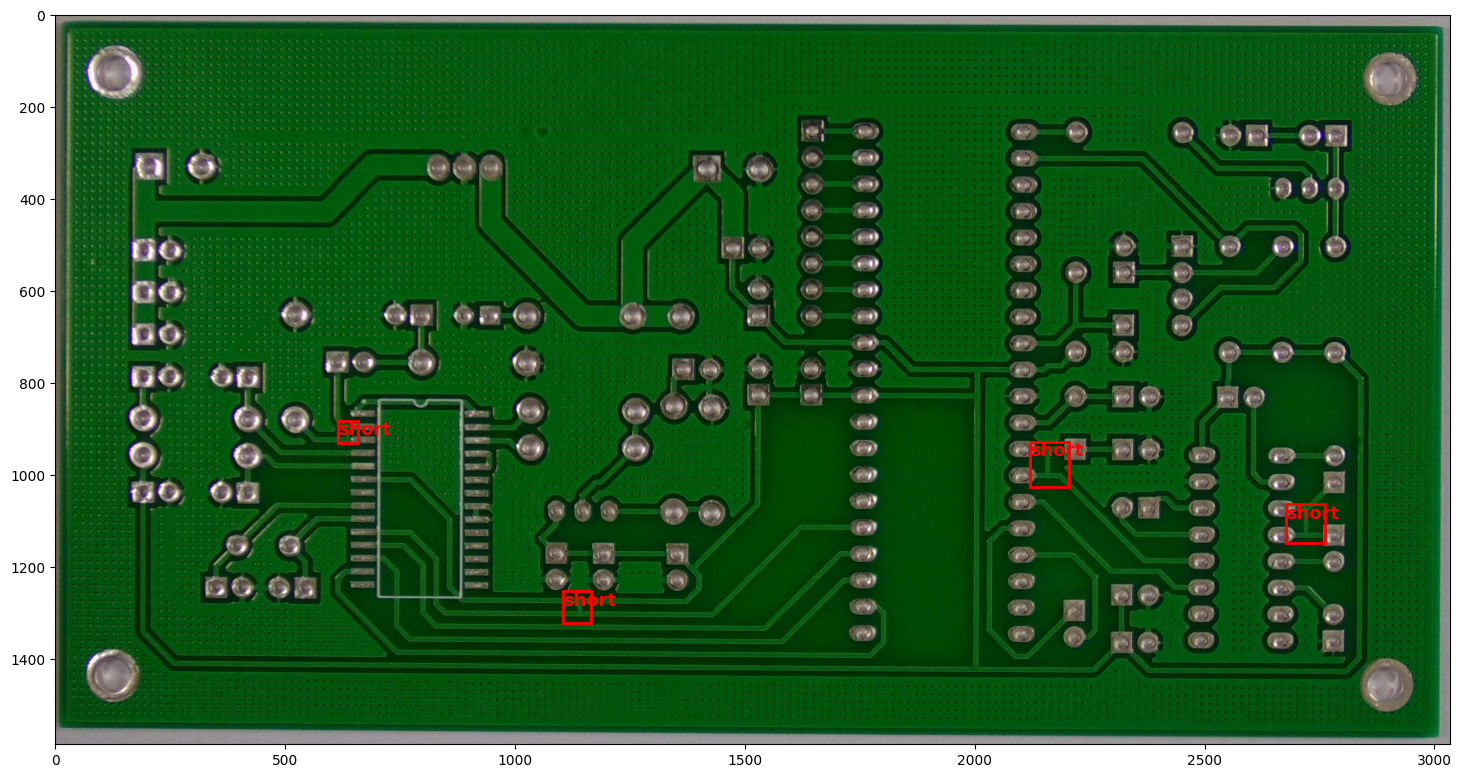

In [ ]:
img, tar, _ = pcb_dataset[random.randint(0,50)]
bbox = tar['boxes']
fig,ax = plt.subplots(figsize=(18,10))
ax.imshow(img.permute(1,2,0).cpu().numpy())
for j in tar["labels"].tolist():
    classes_la = {1:"missing_hole", 2: "mouse_bite", 3:"open_circuit",4: "short", 5:'spur',6:'spurious_copper'}
    l = classes_la[j]
    for i in range(len(bbox)):
        box = bbox[i]
        x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=2,edgecolor='r',facecolor='none',)
        ax.text(*box[:2], l, verticalalignment='top', color='red', fontsize=13, weight='bold')
        ax.add_patch(rect)
    plt.show()

In [ ]:
image_ids=df['file'].unique()
print(len(image_ids))

693


Split data into training and test

In [ ]:
valid_df = train.sample(frac=0.1, random_state=42)
indices_to_remove = valid_df.index
train_df = train.drop(indices_to_remove)
test_df = test
train_df.shape,valid_df.shape

((2126, 8), (236, 8))

# V. Dataloader

In [ ]:
path

'/root/.cache/kagglehub/datasets/akhatova/pcb-defects/versions/1/PCB_DATASET/images/'

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))
        ## It takes a list of individual data samples and assemble them into a batch that can be processed by your model

In [ ]:
train_dataset = pcbdata(train_df, path, get_train_transform())
valid_dataset = pcbdata(valid_df, path, get_valid_transform())
test_dataset  = pcbdata(test_df , path, get_test_transform() )
## DataLoader helps to create batches from the data

indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=6,
    collate_fn=collate_fn
)
## Dataloader creates data into batches
valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=6,
    collate_fn=collate_fn
)

test_data_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=6,
    collate_fn=collate_fn
)

In [ ]:
## calculate length of training, testing, validation data
print(len(train_data_loader),len(valid_data_loader),len(test_data_loader))

684 212 416


Most pretrained models are trained with a background class, we'll include it in our model, so in that case our number of classes will be 6

In [ ]:
def load_model():
  num_classes = 6+1 ## classes + background
  ## Resnet not account for background class
  ## But fastercnn_resnet50_fpn does
  ## we are loading a model which is pre trained on COCO dataset
  weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
  model = fasterrcnn_resnet50_fpn(weights=weights)
  input_feature = model.roi_heads.box_predictor.cls_score.in_features

  model.roi_heads.box_predictor = FastRCNNPredictor(input_feature, num_classes)
  return model

In [ ]:
model=load_model()
for name, params in model.named_parameters():
    if params.requires_grad and name.__contains__("predict"):
        print(name)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 107MB/s] 


roi_heads.box_predictor.cls_score.weight
roi_heads.box_predictor.cls_score.bias
roi_heads.box_predictor.bbox_pred.weight
roi_heads.box_predictor.bbox_pred.bias


In [ ]:
def load_params():
    model=load_model()
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.Adam(params, lr=0.0001, weight_decay=0.0005,)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    return model,params,optimizer,lr_scheduler

# VI. Training and evaluation

In [ ]:
train_data_loader

In [ ]:
def orthogonal_loss(lembda):
    extra_norm=0.
    for m in model.modules():
        if isinstance(m,torch.nn.Linear) or isinstance(m,torch.nn.Conv2d):
            tmp=m.weight.view(m.weight.data.size(0), -1)
            s1,s2=tmp.shape # For unequal matrices semi orthogonal condition is imposed
            if s1<s2:
                extra_norm+=torch.norm(torch.mm(tmp,tmp.t())-torch.eye(s1),p='fro')
            else:
                extra_norm+=torch.norm(torch.mm(tmp.t(),tmp)-torch.eye(s2),p='fro')
    return lembda*extra_norm

In [ ]:
lembdas = [0.,0.0001,0.001,0.01]
loss_curves = []
IOU_curves = []
models  = []

for lembda in lembdas:

    min_loss = sys.maxsize
    num_epochs = 25

    model=load_model()
    models.append(model)
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.Adam(params, lr=0.0001, weight_decay=0.0005,)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    loss_curve=[]
    IOU_curve=[]

    for epoch in range(num_epochs):
        tk = tqdm(train_data_loader)
        model.train()
        running_loss = 0.
        for images, targets, image_ids in tk:
            # Shifting everyth for image in images)
            targets = [{k: v for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)

            losses = sum(loss for loss in loss_dict.values())
            loss_value = losses + orthogonal_loss(lembda)
            running_loss+=loss_value.item()

            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()

            loss_curve.append(loss_value.item())
            tk.set_postfix(train_loss=loss_value.item())
        tk.close()
        running_loss/=len(train_data_loader)
        loss_curve.append(running_loss)

        # update the learning rate
        if lr_scheduler is not None:
            lr_scheduler.step()

        print(f"Epoch #{epoch} loss: {loss_value.item()}")

        #validation
        model.eval();
        with torch.no_grad():
            tk = tqdm(valid_data_loader)
            running_IOU=0.
            for images, targets, image_ids in tk:
                # Shifting everthing to CUDA (NO CHANGE IN DATA)
                images = list(image for image in images)
                targets = [{k: v for k, v in t.items()} for t in targets]
                val_output = model(images)
                val_output = [{k: v for k, v in t.items()} for t in val_output]
                IOU = []
                for j in range(len(val_output)):
                    a,b = val_output[j]['boxes'].cpu().detach(), targets[j]['boxes'].cpu().detach()
                    chk = torchvision.ops.box_iou(a,b)
                    res = np.nanmean(chk.sum(axis=1)/(chk>0).sum(axis=1))
                    if np.isnan(res):
                        res = 0.0
                    IOU.append(res)
                running_IOU += np.nanmean(IOU)
                tk.set_postfix(IoU=np.nanmean(IOU))
            running_IOU/=len(valid_data_loader)
            IOU_curve.append(running_IOU)
            tk.close()
        print("IOU Average Measure ",IOU_curve[-1])
    IOU_curves.append(IOU_curve)
    loss_curves.append(loss_curve)
    models.append(model)

  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #0 loss: 0.27658589157298075


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.4857833073440166


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #1 loss: 0.33370052278226325


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.5562456384461167


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #2 loss: 0.4074418738429969


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6060054888258553


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #3 loss: 0.15308195074370695


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6712033110813694


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #4 loss: 0.22416938789024288


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6771680789615122


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #5 loss: 0.1417141798853804


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6921020748102991


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #6 loss: 0.22002121067729766


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6852304724981931


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #7 loss: 0.22960060857222137


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6830932727016774


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #8 loss: 0.07251271288949492


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6829452477146732


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #9 loss: 0.2416598817008391


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6810087976383299


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #10 loss: 0.10716253346998231


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6790355226280901


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #11 loss: 0.11778259570770419


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6796171131114516


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #12 loss: 0.132571611746518


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.67962298412641


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #13 loss: 0.1903709224799915


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6796945885124248


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #14 loss: 0.05214829790888336


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.679699742763774


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #15 loss: 0.1091300032553881


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6797002813306683


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #16 loss: 0.16448883288267868


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6797007260161149


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #17 loss: 0.20892647074811072


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6797009179314608


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #18 loss: 0.1751906289727662


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6797009246833758


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #19 loss: 0.06845849211900265


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6797009985923066


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #20 loss: 0.14811784669909658


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6797009468303


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #21 loss: 0.10210515999995877


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6797009646117576


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #22 loss: 0.24395768473858448


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6797009535097082


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #23 loss: 0.2180196837096168


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6797009681097553


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #24 loss: 0.12394751229686213


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6797009624145796


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #0 loss: 0.4993506098128591


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.47539356053303916


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #1 loss: 0.177425635989036


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.5865412112713956


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #2 loss: 0.4234998138006723


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.5874718048799351


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #3 loss: 0.27331412722667037


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6725474811092876


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #4 loss: 0.29312021997394355


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6896545902527966


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #5 loss: 0.25950026704482476


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.686071273301982


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #6 loss: 0.2096872775564324


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.679985595135238


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #7 loss: 0.14010161950108405


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6817792275599157


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #8 loss: 0.2281465789162643


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.682094838529814


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #9 loss: 0.2672777311042943


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6827098576757874


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #10 loss: 0.21591575980968641


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6825995102321296


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #11 loss: 0.22440245071676465


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6828199575569139


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #12 loss: 0.15345942210143437


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.682701805707589


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #13 loss: 0.3027272078117783


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6827026082048252


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #14 loss: 0.2360947573700615


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6827033224504898


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #15 loss: 0.2652884569805669


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6827420763221703


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #16 loss: 0.19815906172188563


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6827422519746391


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #17 loss: 0.21870879949647193


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6827423760056558


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #18 loss: 0.26017647831205215


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6827423498096481


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #19 loss: 0.28638918727057583


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6827422999954935


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #20 loss: 0.25953512701553


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6827423224092556


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #21 loss: 0.29130798061318397


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6827423759215144


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #22 loss: 0.2352547209687064


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6827423501091914


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #23 loss: 0.22333961209729994


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6827423290703905


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #24 loss: 0.1492166479854455


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6827423323467654


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #0 loss: 1.2894341805840432


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.5085911375832018


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #1 loss: 1.3896831499779005


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.5347031804643657


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #2 loss: 1.1353750826702729


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.5251753009405816


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #3 loss: 1.2195224715842707


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6576400326434745


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #4 loss: 1.1001074368920474


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6778998280105438


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #5 loss: 1.17831250290081


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6836768531088365


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #6 loss: 1.1585429560980023


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6972418081482837


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #7 loss: 1.1337191136686644


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.7006234973635727


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #8 loss: 1.1678257472173081


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6999842467725851


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #9 loss: 1.095154816851271


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6998439606021051


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #10 loss: 1.2256972373354451


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6999205181819538


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #11 loss: 1.0757287609752608


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.7010295799285842


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #12 loss: 1.114809704901841


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.7007532261700461


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #13 loss: 1.1379145596198381


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.7007589204573809


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #14 loss: 1.0760633969510414


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.7007642339931832


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #15 loss: 1.115849327945618


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.7007648911476428


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #16 loss: 1.0393340765586507


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.7007652132712631


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #17 loss: 1.0808975273160324


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.7007654860688187


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #18 loss: 1.1065741954449377


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.7007654765439901


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #19 loss: 1.1725975426916877


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.700765542240496


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #20 loss: 1.0958352840273027


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.7007655285676817


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #21 loss: 1.0598638166995302


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.7007655464364169


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #22 loss: 1.0699948585905394


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.7007655324446708


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #23 loss: 1.2329540522714098


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.7007655278998736


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #24 loss: 1.1031232286402581


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.700765517111382


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #0 loss: 7.605352618821192


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.5298753641357058


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #1 loss: 6.16057377841604


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.5760051920958477


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #2 loss: 5.197160675289225


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6048129961685043


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #3 loss: 4.904992781272279


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.682377737400034


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #4 loss: 4.815865666318547


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6953677680245238


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #5 loss: 4.794298688226286


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.7059499534978343


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #6 loss: 4.696256082390424


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.7032742582558992


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #7 loss: 4.671211568757879


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.704354321676343


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #8 loss: 4.755521669472561


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6995451048432517


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #9 loss: 4.638045149554892


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6996217566603947


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #10 loss: 4.7480558334681735


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.7000496569451192


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #11 loss: 4.650780390836737


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.7008760183237176


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #12 loss: 4.615975342607984


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.7008788774155265


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #13 loss: 4.698462785936327


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.7008524206809102


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #14 loss: 4.6847292550493185


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.7008544149362295


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #15 loss: 4.697392463464447


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.700854491601296


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #16 loss: 4.650667814719602


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.7007643108840999


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #17 loss: 4.682675186925491


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.7010005638403792


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #18 loss: 4.642757153593638


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.7010005622387246


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #19 loss: 4.6015438096092325


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.7010006105610614


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #20 loss: 4.730737759645768


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.7010005996942352


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #21 loss: 4.64835671661354


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.7010005479797814


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #22 loss: 4.60796949296719


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.7010005813317587


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #23 loss: 4.680230852345861


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.7010005741317518


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #24 loss: 4.615557041444


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.7010005978585976


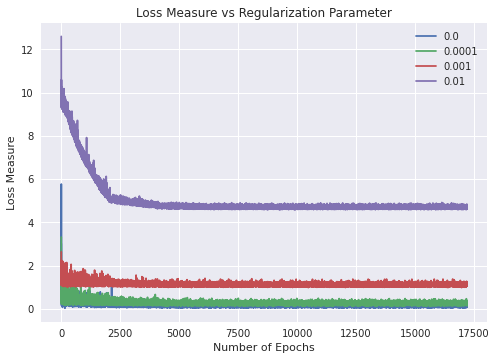

In [ ]:
plt.style.use('seaborn')
for lc,l in zip(loss_curves,lembdas):
    plt.plot(lc,label=l)
plt.legend()
plt.xlabel("Number of Epochs")
plt.ylabel("Loss Measure")
plt.title("Loss Measure vs Regularization Parameter")
plt.savefig('loss_curves.png')
plt.show()

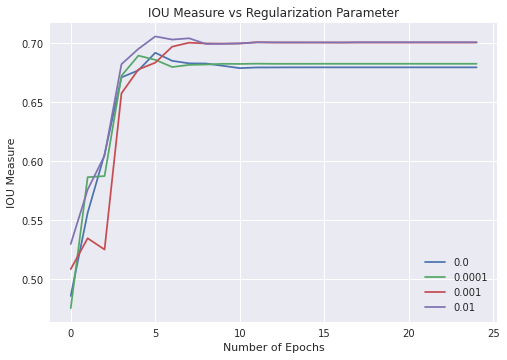

In [ ]:
for ic,l in zip(IOU_curves,lembdas):
    plt.plot(ic,label=l)
plt.legend()
plt.xlabel("Number of Epochs")
plt.ylabel("IOU Measure")
plt.title("IOU Measure vs Regularization Parameter")
plt.savefig('iou_curves.png')
plt.show()

##### Sample evaluation on validation dataset image

In [ ]:
img,target,_ = valid_dataset[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img])[0]

print('predicted #boxes: ', len(prediction['boxes']))
print('real #boxes: ', len(target['boxes']))

predicted #boxes:  5
real #boxes:  1


In [ ]:
for model,lembda in zip(models,lembdas):
    model_path = 'model_{}.pth'.format(lembda)
    torch.save(model.state_dict(),model_path)

# VII. Evaluation

In [ ]:
# y_true =[]
# y_pred = []
# for data in valid_dataset:
#     img,target,_ = data
#     model.eval()
#     with torch.no_grad():
#         y_true.append(target['labels'][0])
#         prediction = model([img.to(device)])[0]
#         if len(prediction['labels'])==0:
#             y_pred.append(torch.tensor(0).to(device))
#         else:
#             y_pred.append(prediction['labels'][0])

In [ ]:
# yy_pred = []
# for v in y_pred:
#     yy_pred.append(v.cpu())

In [ ]:
# from sklearn.metrics import confusion_matrix
# confusion_matrix(y_true, yy_pred)

In [ ]:
# from sklearn.metrics import classification_report
# print(classification_report(y_true, yy_pred))

In [ ]:



# defect_names = {
#     1: "Missing Hole",
#     2: "Open Circuit",
#     3: "Short Circuit",
#     4: "Mouse Bite",
#     5: "Spur",
#     6: "Copper Trace Cut"
# }
# # Load the model
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, num_classes=7)
# in_features = model.roi_heads.box_predictor.cls_score.in_features
# model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=7)
# model.load_state_dict(torch.load('/kaggle/working/pcbdetection.pt'))
# model.eval()
# model.to(device)

# # Load the image
# image_path = '/root/.cache/kagglehub/datasets/akhatova/pcb-defects/versions/1/PCB_DATASET/images/Mouse_bite/01_mouse_bite_03.jpg'
# image = cv2.imread(image_path)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# image = image / 255.0

# # Define the transformation to apply to the image
# transform = T.Compose([T.ToTensor()])

# # Apply the transformation to the image
# image = transform(image).to(device)

# # Predict the bounding boxes and labels for the image
# image = image.float()
# outputs = model([image])
# boxes = outputs[0]['boxes'].detach().cpu().numpy()
# labels = outputs[0]['labels'].detach().cpu().numpy()

# # Visualize the image and the predicted bounding boxes
# fig, ax = plt.subplots(figsize=(12, 8))
# ax.imshow(image.permute(1, 2, 0).cpu().numpy())
# for box, label in zip(boxes, labels):
#     x1, y1, x2, y2 = box
#     w, h = x2 - x1, y2 - y1
#     rect = matplotlib.patches.Rectangle((x1, y1), w, h, linewidth=2, edgecolor='r', facecolor='none')
#     ax.add_patch(rect)
#     ax.text(x1-20, y2 + 150, defect_names[label], fontsize=12, color='g', backgroundcolor='w')
# plt.show()

# VIII. Testing Results

In [ ]:
# load_path = '../input/models-and-results-with-10-eopchs/'
# os.listdir(load_path)

In [ ]:
# lembdas=[0.0,0.0001,0.001,0.01]
# models= []
# for lembda in lembdas:
#     model_path = 'model_{}.pth'.format(lembda)
#     model_path=load_path+model_path
#     print(model_path)
#     model=load_model()
#     checkpoint=torch.load(model_path)
#     models.append(model)

In [ ]:
def check(model):
  defect_names = {
          1: "Missing Hole",
          2: "Open Circuit",
          3: "Short Circuit",
          4: "Mouse Bite",
          5: "Spur",
          6: "Copper Trace Cut"
      }

  model.eval()


  # Load the image
  image_path = '/root/.cache/kagglehub/datasets/akhatova/pcb-defects/versions/1/PCB_DATASET/images/Mouse_bite/01_mouse_bite_03.jpg'
  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = image / 255.0

  # Define the transformation to apply to the image
  transform = T.Compose([T.ToTensor()])

  # Apply the transformation to the image
  image = transform(image)

  # Predict the bounding boxes and labels for the image
  image = image.float()
  with torch.no_grad():
      outputs = model([image])
  print(outputs[0])
  boxes = outputs[0]['boxes'].detach().cpu().numpy()
  labels = outputs[0]['labels'].detach().cpu().numpy()

  # Visualize the image and the predicted bounding boxes
  fig, ax = plt.subplots(figsize=(12, 8))
  ax.imshow(image.permute(1, 2, 0).cpu().numpy())
  for box, label in zip(boxes, labels):
          x1, y1, x2, y2 = box
          w, h = x2 - x1, y2 - y1
          rect = matplotlib.patches.Rectangle((x1, y1), w, h, linewidth=2, edgecolor='r', facecolor='none')
          ax.add_patch(rect)
          ax.text(x1-20, y2 + 150, defect_names[label], fontsize=12, color='g', backgroundcolor='w')
  plt.show()

{'boxes': tensor([[2560.4626,  547.5857, 2601.6633,  580.4943],
        [1939.2875,  756.3647, 1972.9211,  784.8655],
        [2595.2874,  888.9279, 2626.6519,  930.7502],
        [2562.7253,  546.5344, 2610.0076,  581.7510]], device='cuda:0'), 'labels': tensor([2, 2, 2, 5], device='cuda:0'), 'scores': tensor([0.9730, 0.9625, 0.9090, 0.0639], device='cuda:0')}


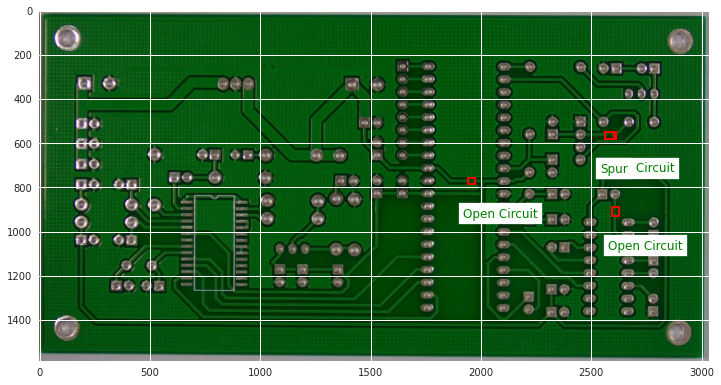

{'boxes': tensor([[2560.4626,  547.5857, 2601.6633,  580.4943],
        [1939.2875,  756.3647, 1972.9211,  784.8655],
        [2595.2874,  888.9279, 2626.6519,  930.7502],
        [2562.7253,  546.5344, 2610.0076,  581.7510]], device='cuda:0'), 'labels': tensor([2, 2, 2, 5], device='cuda:0'), 'scores': tensor([0.9730, 0.9625, 0.9090, 0.0639], device='cuda:0')}


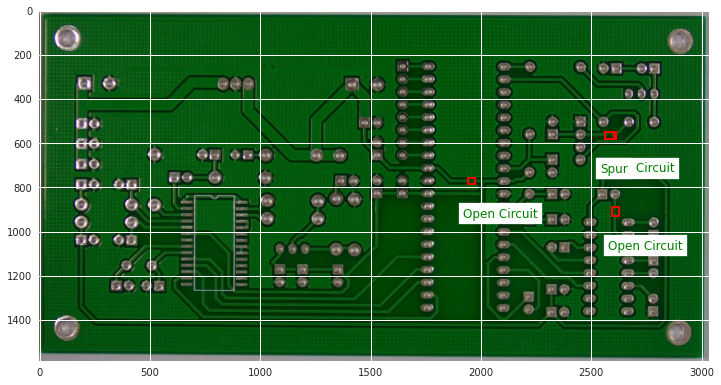

{'boxes': tensor([[2558.9736,  547.6074, 2603.2498,  581.9134],
        [1939.7291,  755.7220, 1972.9493,  785.7739],
        [2595.7078,  888.6089, 2625.0732,  930.9487],
        [2599.9854,  892.8127, 2622.0708,  928.3077],
        [1930.5082,  753.3495, 1962.6473,  788.1544]], device='cuda:0'), 'labels': tensor([2, 2, 2, 3, 5], device='cuda:0'), 'scores': tensor([0.9725, 0.9648, 0.8265, 0.0735, 0.0683], device='cuda:0')}


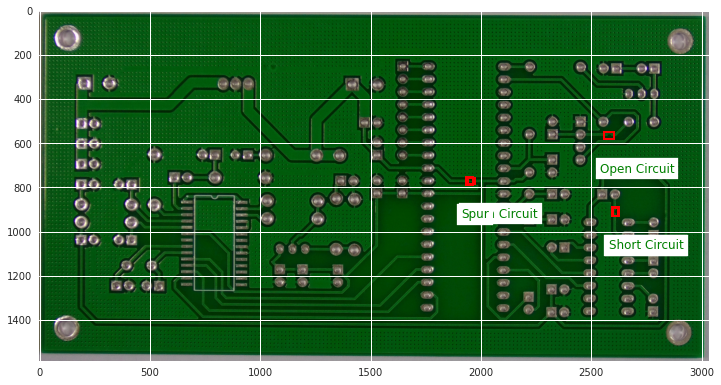

{'boxes': tensor([[2558.9736,  547.6074, 2603.2498,  581.9134],
        [1939.7291,  755.7220, 1972.9493,  785.7739],
        [2595.7078,  888.6089, 2625.0732,  930.9487],
        [2599.9854,  892.8127, 2622.0708,  928.3077],
        [1930.5082,  753.3495, 1962.6473,  788.1544]], device='cuda:0'), 'labels': tensor([2, 2, 2, 3, 5], device='cuda:0'), 'scores': tensor([0.9725, 0.9648, 0.8265, 0.0735, 0.0683], device='cuda:0')}


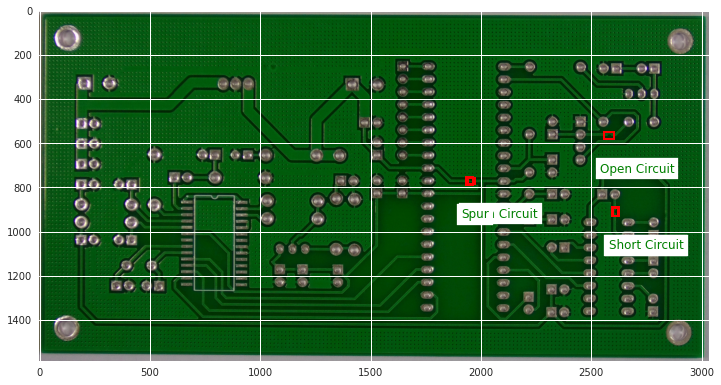

{'boxes': tensor([[2593.2952,  888.4848, 2626.0500,  931.7546],
        [2561.4143,  547.4579, 2602.8494,  581.3536],
        [1940.3605,  756.6135, 1972.5458,  785.8331],
        [2591.4282,  868.8433, 2622.2336,  916.8582],
        [2561.3154,  543.4138, 2606.0173,  582.2087]], device='cuda:0'), 'labels': tensor([2, 2, 2, 5, 5], device='cuda:0'), 'scores': tensor([0.9637, 0.9567, 0.9451, 0.0799, 0.0605], device='cuda:0')}


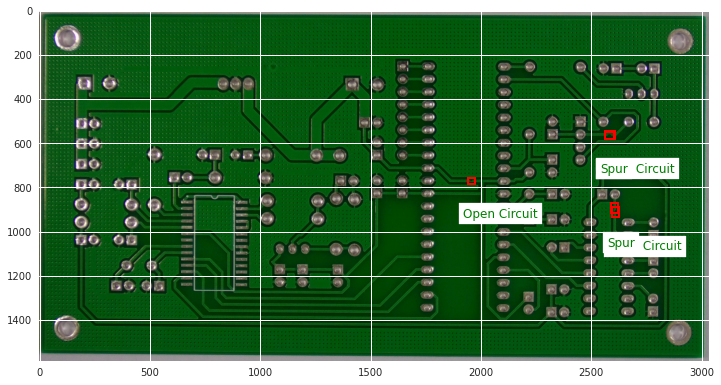

{'boxes': tensor([[2593.2952,  888.4848, 2626.0500,  931.7546],
        [2561.4143,  547.4579, 2602.8494,  581.3536],
        [1940.3605,  756.6135, 1972.5458,  785.8331],
        [2591.4282,  868.8433, 2622.2336,  916.8582],
        [2561.3154,  543.4138, 2606.0173,  582.2087]], device='cuda:0'), 'labels': tensor([2, 2, 2, 5, 5], device='cuda:0'), 'scores': tensor([0.9637, 0.9567, 0.9451, 0.0799, 0.0605], device='cuda:0')}


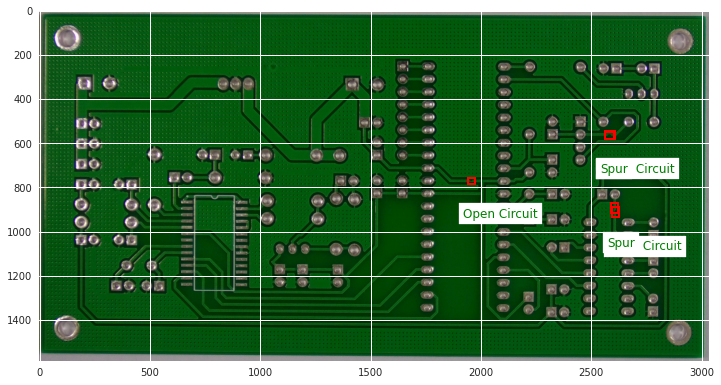

{'boxes': tensor([[2562.7512,  548.0148, 2603.2234,  581.0453],
        [1940.3827,  754.9027, 1973.5314,  786.4860],
        [2595.9949,  890.3172, 2624.2534,  927.7097],
        [2599.1250,  892.8721, 2622.2959,  927.3902],
        [2567.0686,  547.0125, 2606.0527,  577.6531],
        [ 517.7825, 1177.0311,  564.8110, 1220.3273]], device='cuda:0'), 'labels': tensor([2, 2, 2, 3, 5, 3], device='cuda:0'), 'scores': tensor([0.9537, 0.9477, 0.6773, 0.1235, 0.0923, 0.0666], device='cuda:0')}


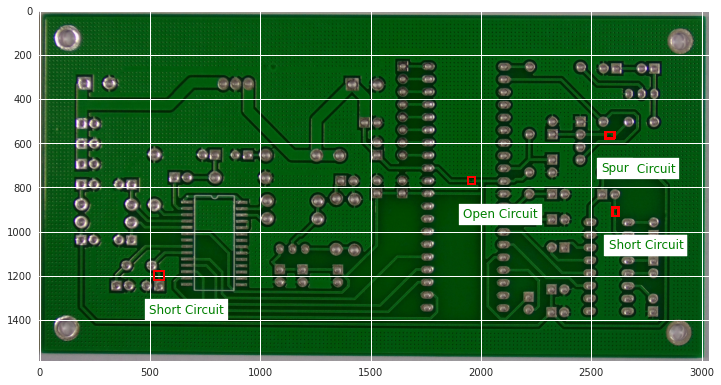

{'boxes': tensor([[2562.7512,  548.0148, 2603.2234,  581.0453],
        [1940.3827,  754.9027, 1973.5314,  786.4860],
        [2595.9949,  890.3172, 2624.2534,  927.7097],
        [2599.1250,  892.8721, 2622.2959,  927.3902],
        [2567.0686,  547.0125, 2606.0527,  577.6531],
        [ 517.7825, 1177.0311,  564.8110, 1220.3273]], device='cuda:0'), 'labels': tensor([2, 2, 2, 3, 5, 3], device='cuda:0'), 'scores': tensor([0.9537, 0.9477, 0.6773, 0.1235, 0.0923, 0.0666], device='cuda:0')}


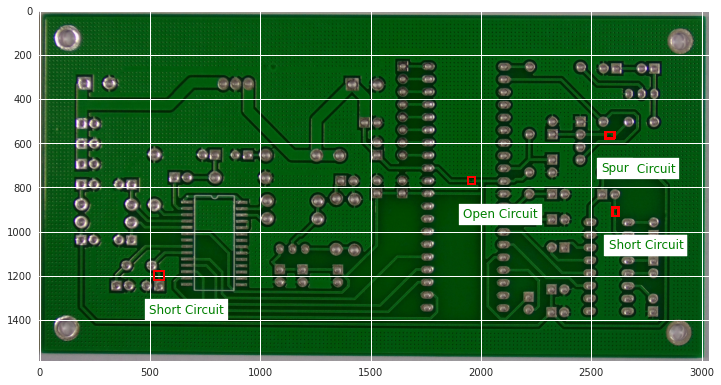

In [ ]:
for model in models:
    check(model)